# Neural Networks from Scratch

We will implement simple neural networks in Python using only `numpy` library (and `matplotlib` for visualization). The idea is to get a strong intuition of how it works. We will visualize the data space and the learning curve, and we will animate these over the learning process and experiment with different parameters. You will need the following libraries:

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import animation, rc
from IPython.display import HTML
import pandas as pd    

np.random.seed(4)

In [2]:
from matplotlib.animation import FuncAnimation

<a id='More_complicated_nn'></a>
## Neural network

Dataset generation

(200, 2)
(200, 2)


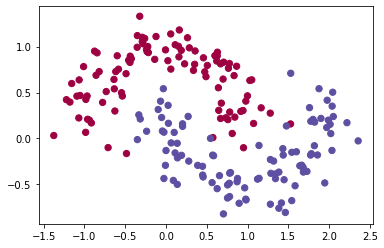

In [3]:
from sklearn import datasets

X, y = datasets.make_moons(200, noise=0.20)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)

n, d = X.shape

# Encode y with one-hot encoding
y = np.concatenate([1-y[:, None], y[:, None]], axis=1)
print(X.shape)
print(y.shape)

 In order to ease the subsequent derivations, we have one-hot encoded $y$.
 
 We want to build a network with one hidden layer. The number of neurons in this network will be a variable called `d_h1`.  Let us define the following variables. 

In [4]:
n = len(X) # training set size
d_in = 2 # input layer dimensionality
d_out = 2 # output layer dimensionality
 
# Gradient descent parameters
eta = 0.01 # learning rate for gradient descent
lmbda = 0 # regularization strength for a L2 penalization over the weights (but not over the bias)

A network is defined by its parameters. We will thus define a dictionnary to describe a network, this dictionnary being composed of four elements named `W1`,`b1`,`W2`,`b2`
. We use hyperbolic tangents as activation functions, the softmax as output function and the negative log likelihood as the loss function (also called cross-entropy). 

The equations defining the network are 

\begin{align*}
z^{(1)} & = W^{(1)} x + b^{(1)}\\
a^{(1)} & = \tanh(z^{(1)}) \\
z^{(2)} & = W^{(2)} a^{(1)} + b^{(2)} \\
a^{(2)} & = \hat{y} = \textrm{softmax}(z^{(2)}) 
\end{align*}

where $x, z^{(1)}, a^{(1)}$ are arrays of size $(2, n)$ (where $n$ is the number of samples), $z^{(2)}, a^{(2)}$ are of size (`d_h1`, $n$), and $b^{(1)},  b^{(2)}$ are vectors of size `d_h1` and `d_out` respectively. Letting $ \hat{y}$ be the $(2,n)$ array containing the predicted probabilities for each class as above, the negative log loss (or cross entropy loss) is given by 
\begin{align*}
\ell(y,\hat{y}) & = - \frac{1}{n} \sum_{i=1}^n \sum_{k=0}^1 y_{k, i} \log(\hat y_{k, i})
\end{align*}

**Now, create two functions, the first one `calculate_loss(model)` to compute the loss of a model on the entire data set and the second one `predict(model,x)` to predict the output of a model for a new observation `x`.**

In [5]:
# Helper function to evaluate the total loss on the dataset
#####################
# TO DO 
def predict_proba(model, X):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    z1 = W1.dot(X.T) + b1[:, None]
    a1 = np.tanh(z1)
    z2 = W2.dot(a1) + b2[:, None]
    z2_exp = np.exp(z2)
    y_hat = z2_exp/np.sum(z2_exp, axis=0)
    return y_hat

def compute_loss(model, X):
    y_hat = predict_proba(model, X)
    tmp = np.log(y_hat)*y.T
    tmp = tmp.sum(axis=0)
    return -tmp.mean()
# END TO DO 
#####################

# Helper function to predict an output (0 or 1)
#####################
# TO DO
def predict(model, X):
    y_hat = predict_proba(model, X)
    return np.argmax(y_hat, axis=0)
# END TO DO 
#####################


# Test
np.random.seed(0)
d_h1 = 2
W1 = np.random.randn(d_h1, d_in) / np.sqrt(d_in)
b1 = np.zeros(d_h1)
W2 = np.random.randn(d_out, d_h1) / np.sqrt(d_h1)
b2 = np.zeros(d_out)

model = {}
model['W1'], model['W2'], model['b1'], model['b2'] = W1, W2, b1, b2
loss = compute_loss(model, X)
pred = predict(model, X)

print(loss)
print(np.mean(pred==y[:, 1]))

0.8486056473915673
0.19


**`build_model(nn_hdim, num_passes=20000, print_loss=False)` to build the network.** 

In [6]:
def build_model(d_h1, n_epochs=20000, print_loss=False):
    
    # Initialize the parameters to random values. We need to learn these.
    np.random.seed(0)
    W1 = np.random.randn(d_h1, d_in) / np.sqrt(d_in)
    b1 = np.zeros(d_h1)
    W2 = np.random.randn(d_out, d_h1) / np.sqrt(d_h1)
    b2 = np.zeros(d_out)
    
    losses = []
    
    # Gradient descent. For each batch...
    for i in range(0, n_epochs):
                
        # Forward propagation
        z1 = W1.dot(X.T) + b1[:, None]
        a1 = np.tanh(z1)
        z2 = W2.dot(a1) + b2[:, None]
        z2_exp = np.exp(z2)
        y_hat = z2_exp/np.sum(z2_exp, axis=0)
        
        # Backpropagation
        grad_z2 = y_hat - y.T
        grad_z1 = (grad_z2.T.dot(W2))*(1-np.tanh(z1.T)**2)
        grad_z1 = grad_z1.T
        
        grad_W2 = grad_z2.dot(a1.T)
        grad_W1 = grad_z1.dot(X)
        grad_b2 = grad_z2.sum(axis=1)
        grad_b1 = grad_z1.sum(axis=1)
        
        
        # Add regularization terms (b1 and b2 don't have regularization terms)
        grad_W1 += lmbda * W1
        grad_W2 += lmbda * W2
        
        # Gradient descent parameter update
        W1 += -eta * grad_W1
        W2 += -eta * grad_W2
        b1 += -eta * grad_b1
        b2 += -eta * grad_b2

        # Assign new parameters to the model
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
        
        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 50 == 0:
            loss = compute_loss(model, X)
            print(f'Loss after iteration {i}: {loss}')
            losses.append(loss)
        
        
            
    return model, losses

In [7]:
# Helper function to plot a decision boundary.
def plot_decision_boundary(model):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    grid = np.arange(x_min, x_max, h)
    xx, yy = np.meshgrid(grid, grid)
    # Predict the function value for the whole grid
    X_grid = np.c_[xx.ravel(), yy.ravel()]
    Z = predict(model, X_grid)
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.5)
    plt.scatter(X[:, 0], X[:, 1], c=y[:, 1], cmap=plt.cm.Spectral)

In [10]:
model, losses = build_model(5, n_epochs=20000, print_loss=True)

Loss after iteration 0: 0.46433019487190963
Loss after iteration 50: 0.17975632412573336
Loss after iteration 100: 0.09263040611875527
Loss after iteration 150: 0.061291249347257645
Loss after iteration 200: 0.05150059761062222
Loss after iteration 250: 0.04672982094774225
Loss after iteration 300: 0.043902879882091135
Loss after iteration 350: 0.041827155245172117
Loss after iteration 400: 0.04002844489181236
Loss after iteration 450: 0.038450441654907984
Loss after iteration 500: 0.03706997697841049
Loss after iteration 550: 0.03587553703926672
Loss after iteration 600: 0.03485429306731585
Loss after iteration 650: 0.033985811972313956
Loss after iteration 700: 0.03324468243123474
Loss after iteration 750: 0.03260523450336791
Loss after iteration 800: 0.032044550117868276
Loss after iteration 850: 0.031543414102888245
Loss after iteration 900: 0.03108605380837329
Loss after iteration 950: 0.03065940727477522
Loss after iteration 1000: 0.030252300914705998
Loss after iteration 1050: 0

Loss after iteration 9350: 0.011194649205245943
Loss after iteration 9400: 0.011179412356210807
Loss after iteration 9450: 0.01116435078940391
Loss after iteration 9500: 0.01114946183191796
Loss after iteration 9550: 0.011134742823097905
Loss after iteration 9600: 0.011120191118224041
Loss after iteration 9650: 0.011105804091878647
Loss after iteration 9700: 0.011091579141005918
Loss after iteration 9750: 0.011077513687675773
Loss after iteration 9800: 0.011063605181561034
Loss after iteration 9850: 0.011049851102142209
Loss after iteration 9900: 0.011036248960652004
Loss after iteration 9950: 0.011022796301773108
Loss after iteration 10000: 0.011009490705102964
Loss after iteration 10050: 0.010996329786400295
Loss after iteration 10100: 0.010983311198626175
Loss after iteration 10150: 0.010970432632796243
Loss after iteration 10200: 0.01095769181865381
Loss after iteration 10250: 0.010945086525181663
Loss after iteration 10300: 0.010932614560963323
Loss after iteration 10350: 0.010920

Loss after iteration 17800: 0.009887807648686528
Loss after iteration 17850: 0.00988389391809686
Loss after iteration 17900: 0.009880002788154853
Loss after iteration 17950: 0.009876134062440369
Loss after iteration 18000: 0.009872287546773571
Loss after iteration 18050: 0.009868463049182378
Loss after iteration 18100: 0.009864660379871939
Loss after iteration 18150: 0.009860879351193558
Loss after iteration 18200: 0.009857119777614897
Loss after iteration 18250: 0.009853381475690114
Loss after iteration 18300: 0.009849664264031523
Loss after iteration 18350: 0.00984596796327962
Loss after iteration 18400: 0.009842292396076414
Loss after iteration 18450: 0.009838637387036725
Loss after iteration 18500: 0.009835002762721649
Loss after iteration 18550: 0.009831388351611424
Loss after iteration 18600: 0.009827793984079512
Loss after iteration 18650: 0.00982421949236615
Loss after iteration 18700: 0.009820664710553628
Loss after iteration 18750: 0.009817129474540708
Loss after iteration 18

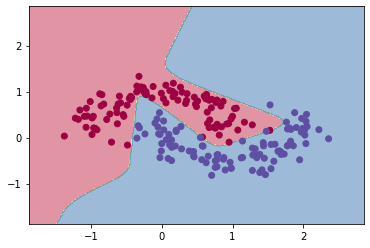

In [11]:
plot_decision_boundary(model)